In [34]:
# import library
import gym
import numpy as np
import torch
from torch.distributions import Categorical
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
from tqdm import tqdm
import random

In [35]:
# on GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
print(device)

cuda


In [36]:
class Policy(nn.Module):
    def __init__(self,input_dim, output_dim):
        super(Policy, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim),
            nn.Softmax(dim = -1)
        )
        
    def forward(self, x):
        return self.fc(x)

## Pseudo-code
policy = Policy() 

optimizer = Adam(policy.params(), lr) 

for 1 - 1000:

    sample traj and store (log(pi_theta), R)

    loss = J

    optimizer.zero_grad()

    loss.backward()

    optim.step

In [37]:
def policy_gradient(env_name, num_episodes, gamma, alpha):
    env = gym.make(env_name)
    input_dim = env.observation_space.shape[0]
    output_dim = env.action_space.n
    
    policy = Policy(input_dim, output_dim).to(device)
    optimizer = optim.Adam(policy.parameters(), lr = alpha)
    
    episode_r = []
    moving_avg_r = []
    
    for episode in tqdm(range(num_episodes), desc = "Traning"):
        state, _ = env.reset()
        log_action_probs = []
        rewards = []
        done = False
        
        while not done:
            # trajectory 
            state_tensor = torch.FloatTensor(state).to(device)
            action_probs = policy(state_tensor)
            
            # sample action
            action = Categorical(action_probs).sample()
            
            # next 
            next_state, r, terminated, truncated, _ = env.step(action.item())
            
            # store log prob and reward
            log_action_probs.append(Categorical(action_probs).log_prob(action))
            rewards.append(r)
            
            # update 
            state = next_state
            done = terminated or truncated
        
        episode_r.append(sum(rewards))
        
        # moving avg
        if len(episode_r) >= 100:
            moving_avg_r.append(np.mean(episode_r[-100:]))
            
        # discount
        R = 0
        discount_r = []
        for r in reversed(rewards):
            R = r + gamma*R
            discount_r.insert(0, R)
        discount_r = torch.FloatTensor(discount_r)
        discount_r = (discount_r - discount_r.mean())/(discount_r.std() + 1e-6)
        
        # loss func
        loss = []
        for log_prob, R in zip(log_action_probs, discount_r):
            loss.append(-log_prob * R)
        loss = torch.stack(loss).sum()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (episode + 1) % 100 == 0:
            tqdm.write(f"Episode {episode + 1} Avgerage Reward: {np.mean(episode_r[-100:])}")
    return policy, episode_r, moving_avg_r

In [38]:
def rollout(enc, policy, num_episodes = 500):
    episode_r = []
    for _ in range(num_episodes):
        state, _ = env.reset()
        total_reward = 0
        done = False
        
        while not done:
            # trajectory 
            state_tensor = torch.FloatTensor(state).to(device)
            action_probs = policy(state_tensor)
            action = torch.argmax(action_probs)
            # next 
            next_state, r, terminated, truncated, _ = env.step(action.item())
            
            # store reward
            total_reward += r
            
            # update 
            state = next_state
            done = terminated or truncated
        
        episode_r.append(total_reward)
        
    return episode_r

In [39]:
# init
env_name = "CartPole-v1"
num_episodes = 1000
discount_factor = 0.95
learning_rate = 0.001

# training
trained_policy, episode_rewards, moving_avg_rewards = policy_gradient(env_name, num_episodes, gamma=discount_factor, alpha=learning_rate)

Traning:   0%|          | 0/1000 [00:00<?, ?it/s]

Traning:  10%|█         | 100/1000 [00:09<02:21,  6.35it/s]

Episode 100 Avgerage Reward: 40.76


Traning:  20%|██        | 201/1000 [00:25<03:40,  3.63it/s]

Episode 200 Avgerage Reward: 75.19


Traning:  30%|███       | 300/1000 [00:57<05:12,  2.24it/s]

Episode 300 Avgerage Reward: 169.53


Traning:  40%|████      | 400/1000 [01:39<05:14,  1.91it/s]

Episode 400 Avgerage Reward: 220.89


Traning:  50%|█████     | 500/1000 [02:37<06:11,  1.35it/s]

Episode 500 Avgerage Reward: 308.2


Traning:  60%|██████    | 600/1000 [03:32<05:10,  1.29it/s]

Episode 600 Avgerage Reward: 329.09


Traning:  70%|███████   | 700/1000 [04:49<04:23,  1.14it/s]

Episode 700 Avgerage Reward: 423.61


Traning:  80%|████████  | 800/1000 [06:19<03:06,  1.07it/s]

Episode 800 Avgerage Reward: 476.88


Traning:  90%|█████████ | 900/1000 [07:39<01:17,  1.29it/s]

Episode 900 Avgerage Reward: 485.0


Traning: 100%|██████████| 1000/1000 [08:54<00:00,  1.87it/s]

Episode 1000 Avgerage Reward: 450.39


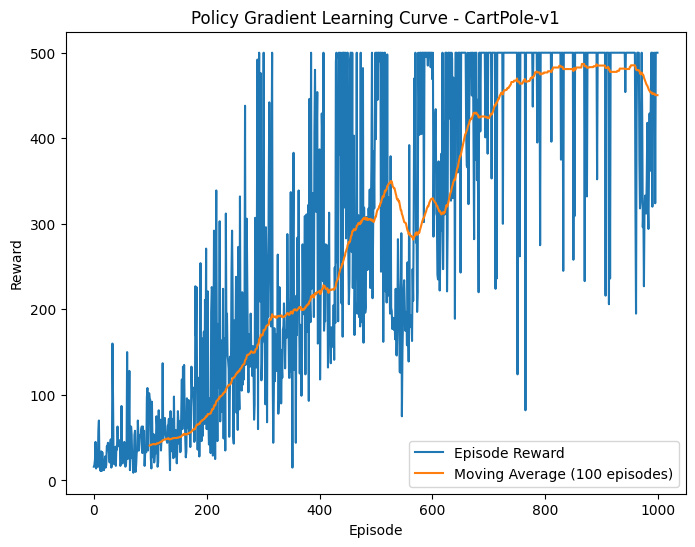

In [40]:
# plotting
plt.figure(figsize=(8, 6))
plt.plot(episode_rewards, label='Episode Reward')
plt.plot(range(99, len(episode_rewards)), moving_avg_rewards, label='Moving Average (100 episodes)')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title(f'Policy Gradient Learning Curve - {env_name}')
plt.legend()
plt.show()

In [41]:
env = gym.make(env_name)
rollout_rewards = rollout(env, trained_policy)

print(f'Mean Reward: {np.mean(rollout_rewards)}')
print(f'Standard Deviation: {np.std(rollout_rewards)}')

Mean Reward: 499.866
Standard Deviation: 2.9933332590942823


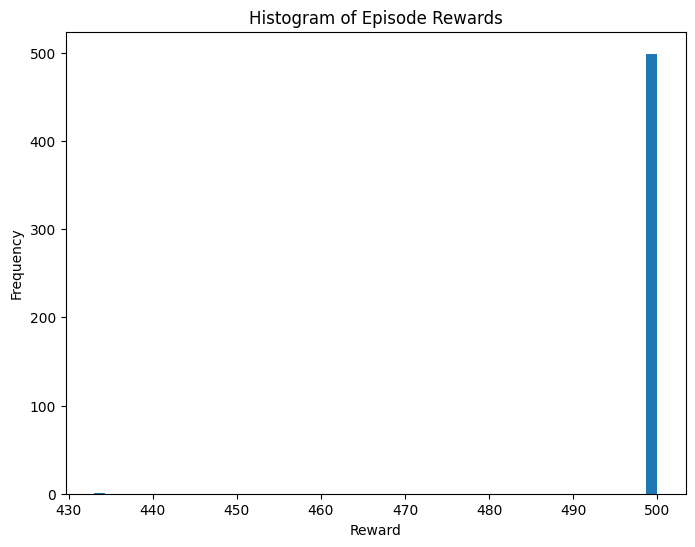

In [42]:
# plotting
plt.figure(figsize=(8, 6))
plt.hist(rollout_rewards, bins=50)
plt.title('Histogram of Episode Rewards')
plt.xlabel('Reward')
plt.ylabel('Frequency')
plt.show()